In [1]:
# basics
import os
import sys
import numpy as np

# plotting
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib import cm

# colab interactive plots and drive
drive = False
if 'google.colab' in sys.modules:
    from  google.colab import drive 
    from google.colab import output
    drive.mount('/content/drive')
    output.enable_custom_widget_manager()
    drive = True
else:
    %matplotlib inline

# other imports
from scipy.ndimage import label, center_of_mass, gaussian_filter, zoom, uniform_filter
from scipy.spatial import KDTree
from scipy.interpolate import griddata
from scipy.stats import norm, gaussian_kde
from skimage.filters import threshold_otsu
from skimage.feature import blob_log

# for cropping function
if drive:
    print('installing DataGenSTEM')
    !pip install ase
    !git clone https://github.com/AustinHouston/DataGenSTEM.git
    sys.path.append('./DataGenSTEM/DataGenSTEM')
    import data_generator as dg

# for Gomb-Net
if drive:
    print('installing Gomb-Net')
    !git clone https://github.com/AustinHouston/Gomb-Net.git
    sys.path.append('./Gomb-Net/')   
from GombNet.networks import *
from GombNet.loss_func import GombinatorialLoss
from GombNet.utils import *

import torch
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


In [2]:
path = '/Users/austin/Desktop/gomb_beta/results.pkl'

import pickle
with open(path, "rb") as f:
    results = pickle.load(f)

In [8]:
results[0].keys()

dict_keys(['image', 'mask', 'probability', 'centroids', 'se_top', 'se_bottom', 's_top', 's_bottom', 'w_top', 'w_bottom', 'map_2H', 'moire_sites', 'distance_arrays'])

0.15805022156573117
0.12000000000000002
0.16792738275340394
0.0867579908675799
0.12210200927357033
0.11613876319758673


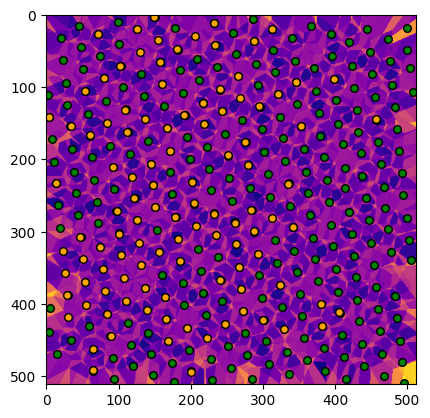

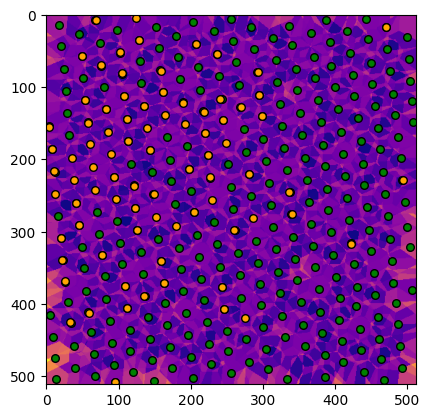

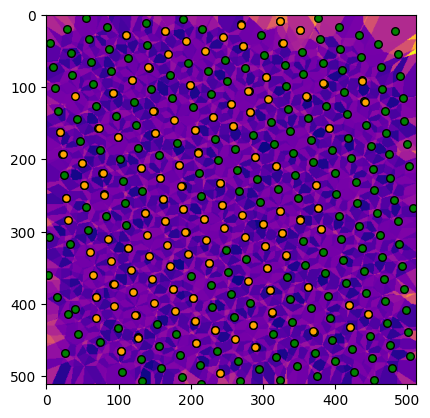

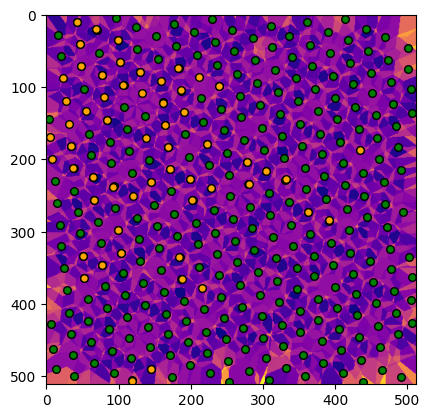

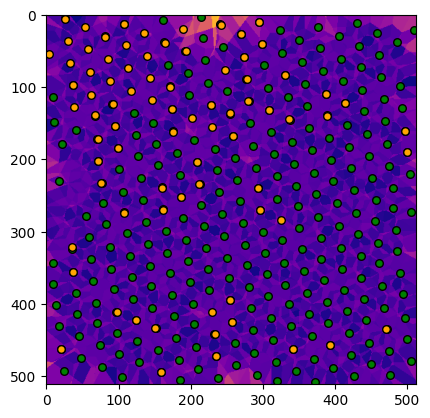

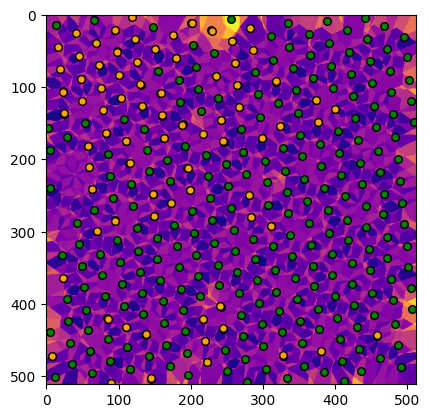

In [23]:
moire_values = []
top_s_moire_values = []
top_se_moire_values = []

# Create meshgrid for points
grid_density = 512
x = np.linspace(0, 512, grid_density)
y = np.linspace(0, 512, grid_density)
X, Y = np.meshgrid(x, y)
points = np.vstack((X.ravel(), Y.ravel())).T


for idx in results.keys():
    map_2H = results[idx]['map_2H']
    se = results[idx]['se_top']
    s = results[idx]['s_top']

    # print out the stoichiometry
    n_Se = len(se)
    n_S = len(s)
    x_stoic = n_Se / (n_S * (2 + n_Se/n_S))
    print(x_stoic)

    # Find where the atom positions (x,y) correlate to the moire value
    s_moire_sites_top = griddata((X.ravel(), Y.ravel()), map_2H.ravel(), (s[:, 1], s[:, 0]), method='cubic')
    se_moire_sites_top = griddata((X.ravel(), Y.ravel()), map_2H.ravel(), (se[:, 1], se[:, 0]), method='cubic')

    moire_values.append(map_2H.ravel())
    top_s_moire_values.append(s_moire_sites_top)
    top_se_moire_values.append(se_moire_sites_top)

    # plot the atoms on the moire map
    plt.figure()
    plt.imshow(map_2H, cmap='plasma')
    
    plt.scatter(s[:,1], s[:,0], c='green', edgecolor='k', s=30)
    plt.scatter(se[:,1], se[:,0], c='orange', edgecolor='k', s=30)



In [43]:
moire_values = np.concatenate([np.ravel(element) for element in moire_values])
top_s_moire_values = np.concatenate([np.ravel(element) for element in top_s_moire_values])
top_se_moire_values = np.concatenate([np.ravel(element) for element in top_se_moire_values])
top_chalchogen_values = np.append(top_s_moire_values, top_se_moire_values)

n_sample = len(top_se_moire_values)
random_sample = np.random.choice(top_chalchogen_values, size=n_sample, replace=False)

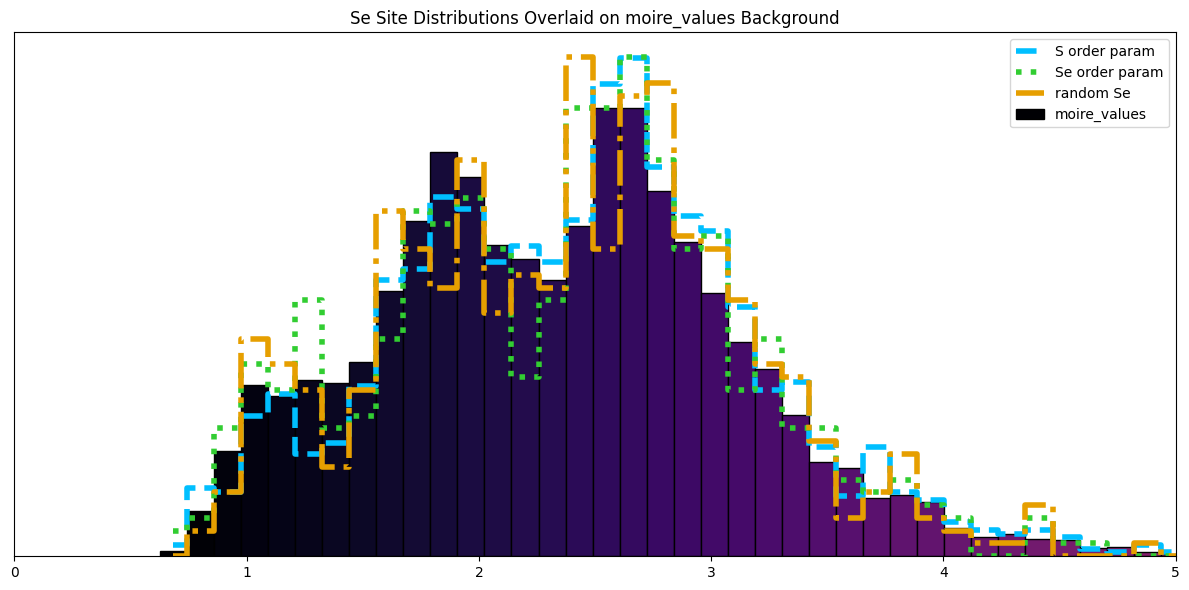

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Create common binning
binedges = np.histogram_bin_edges(np.concatenate([moire_values, top_s_moire_values, top_se_moire_values, top_chalchogen_values]), bins=100)
bin_widths = np.diff(binedges)

# Compute histograms
hist_moire, _ = np.histogram(moire_values, bins=binedges, density=False)
hist_top_s, _ = np.histogram(top_s_moire_values, bins=binedges, density=False)
hist_top_se, _ = np.histogram(top_se_moire_values, bins=binedges, density=False)
hist_top_chalc, _ = np.histogram(random_sample, bins=binedges, density=False) 

# Normalize to densities
hist_moire_density = hist_moire / (np.sum(hist_moire) * bin_widths)
hist_top_s_density = hist_top_s / (np.sum(hist_top_s) * bin_widths)
hist_top_se_density = hist_top_se / (np.sum(hist_top_se) * bin_widths) 
hist_top_chalc_density = hist_top_chalc / (np.sum(hist_top_chalc) * bin_widths)

# Background colormap for moire_values
norm = Normalize(vmin=np.min(moire_values), vmax=np.max(moire_values))
colors = cm.inferno(norm(binedges[:-1]))
ax.bar(binedges[:-1], hist_moire_density, width=bin_widths, color=colors, edgecolor='k', alpha=1, label='moire_values')

# Overlay line plots
ax.step(binedges[:-1], hist_top_s_density, where='mid', color='deepskyblue', linewidth=4, linestyle='--', label='S order param')
ax.step(binedges[:-1], hist_top_se_density, where='mid', color='limegreen', linewidth=4, linestyle=':', label='Se order param')
ax.step(binedges[:-1], hist_top_chalc_density, where='mid', color='#E69F00', linewidth=4, linestyle='-.', label='random Se')

plt.xlim(0,5)
# Aesthetics
ax.legend()
ax.set_yticks([])
ax.set_title("Se Site Distributions Overlaid on moire_values Background")
plt.tight_layout()
plt.show()
